# Music Recommendation Based on Similar Lyrics and Comments

#### Summary:
- Use natural language processing for music recommendation
- Identify and suggest music with similar meanings as songs entered by the user

#### Key Questions:
- How do we obtain song 'meanings'?
- How do we measure the similarities between songs based on texts related to song 'meanings'?
- How do we produce a list of recommendations for a given user?

---
## Part 1: Webscrape song lyrics and Songmeanings.com comments/interpretations

Songmeanings.com contains <b>1,097,225 song lyrics</b> from <b>110,886 artists</b>, and <b>1,737,493 comments/interpretations</b>. To obtain song lyrics/comments, we need to obtain the URLs to the song lyrics/comments page for ~1 million songs. We will use a small premade website index info file (sm_start_info.xlsx) to build out a list of URLs to the A-Z artist directory pages. From there, we will use BeautifulSoup to webscrape the <b>URLs of all 110,886 artist pages</b>, which in turn we will webscrape to obtain the <b>URLs of all 1,097,225 song pages</b>.

In [1]:
%matplotlib inline

# Imports
import numpy as np
import pandas as pd
import requests
import bs4
from bs4 import BeautifulSoup
from IPython.display import clear_output
from time import sleep
from matplotlib import pyplot as plt
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk import FreqDist
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning, module='sklearn') 
warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim')
import gensim
from gensim import corpora, models, similarities
import pyLDAvis
import pyLDAvis.gensim

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\nmf.py:972: DeprecationWarning: invalid escape sequence \s
  """
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\nmf.py:1186: DeprecationWarning: invalid escape sequence \s
  """
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\t_sne.py:420: DeprecationWarning: invalid escape sequence \s
  """


In [2]:
# Load Songmeanings.com directory info 
start_info = pd.read_excel('sm_start_info.xlsx')
start_info.head()

,letter,pages
0,a,155
1,b,170
2,c,153
3,d,161
4,e,76


In [3]:
# Build list of URLs to access artist directories
artist_dir_urls = []
for letter, max_page in start_info.values:
    for page in np.arange(1,max_page+1):
        artist_dir_urls.append('https://songmeanings.com/artist/directory/'+letter+'/?page='+str(page))
artist_dir_urls[:5]

['https://songmeanings.com/artist/directory/a/?page=1',
 'https://songmeanings.com/artist/directory/a/?page=2',
 'https://songmeanings.com/artist/directory/a/?page=3',
 'https://songmeanings.com/artist/directory/a/?page=4',
 'https://songmeanings.com/artist/directory/a/?page=5']

![](artist_dir_page.png)

In [4]:
# Build list of URLs to artist pages 
SCRAPE_ARTIST_URLS = False # Set to False if scraping is already completed

if SCRAPE_ARTIST_URLS == True:
    artist_urls = []
    for artists_page in artist_dir_urls:
        page = requests.get(artists_page)
        soup = BeautifulSoup(page.text, 'lxml')
        table = soup.find('table', summary='songs table')
        table_body = table.find('tbody')
        for item in table_body.find_all('a', href=True):
            artist_urls.append([(item['title']),(item['href'])])
        print ('Scraping artist URLs: '+artists_page)
        clear_output(wait=True)
        sleep(1)
    # Save artist URL list
    artist_urls_df = pd.DataFrame(artist_urls)
    artist_urls_df.to_csv('artist_urls.csv', index=False, header=False)
else:
    artist_urls_df = pd.read_csv('artist_urls.csv', header=None)

In [5]:
artist_urls_df.columns = ['Artist','URL']
artist_urls_df.head()

,Artist,URL
0,A,//songmeanings.com/artist/view/songs/6024/
1,A B,//songmeanings.com/artist/view/songs/137439043...
2,A B & The Sea,//songmeanings.com/artist/view/songs/137438996...
3,A Backward Glance On A Travel Road,//songmeanings.com/artist/view/songs/137439060...
4,A Balladeer,//songmeanings.com/artist/view/songs/137438972...


![](artist_page.png)

In [6]:
# Build list of URLs to song pages 
SCRAPE_SONG_URLS = False # Set to False if scraping is already completed

if SCRAPE_SONG_URLS == True:
    # Save checkpoints
    checkpoints = np.arange(0,110000,1000)

    for count, artist in enumerate(artist_urls_df.values):
        page = requests.get('http:'+artist[1])
        soup = BeautifulSoup(page.text, 'lxml')
        table = soup.find('table', summary='songs table')
        if table != None:
            table_body = table.find('tbody')
            for item in table_body.find_all('tr'):
                song_name = item.find_all('a')[0].contents[0]
                song_url = item.find_all('a')[0]['href']
                num_comments = item.find_all('a')[1].contents[0]
                song_urls.append([artist[0], song_name, song_url, num_comments])
        print('Scraping song URLs for artist: '+artist[0])
        clear_output(wait=True)
        sleep(1)

        # Save at checkpoint
        if count in checkpoints:
            song_urls_df = pd.DataFrame(song_urls)
            song_urls_df.to_csv('song_urls.csv', index=False, header=False)

    song_urls_df = pd.DataFrame(song_urls)
    song_urls_df.to_csv('song_urls.csv', index=False, header=False)
else:
    song_urls_df = pd.read_csv('song_urls.csv', header = None)

In [7]:
song_urls_df.columns = ['Artist','Song','URL','Number of comments']
song_urls_df.head()

,Artist,Song,URL,Number of comments
0,A,"""meditacao"" - (eng: Meditation)",//songmeanings.com/songs/view/91590/,0
1,A,2nd Coming,//songmeanings.com/songs/view/3530822107859283...,0
2,A,40,//songmeanings.com/songs/view/3530822107858486...,0
3,A,6 O'clock On A Tube Stop,//songmeanings.com/songs/view/93649/,1
4,A,8 Fingers,//songmeanings.com/songs/view/3530822107858486...,2


In [8]:
len(song_urls_df[song_urls_df['Number of comments']>=1])

226743

About 20% of songs on Songmeanings.com have at least 1 comment.

In [9]:
len(song_urls_df[song_urls_df['Number of comments']>=10])

37648

About 3% of songs have at least 10 comments.

For this project, we limit our analysis to songs with at least 10 user comments, resulting in 37647 songs. This allows us to have both lyrics and a good amount of comment data for every song. There is also a practical consideration; scraping 1 million songs would take 555 hours (23 days) assuming a 2 second delay between requests.

For each song, we take the top 10 highest rated user comments.

![](song_page.png)

In [10]:
# Functions to extract strings (exclude tagged items) from soup items
def extract_str(soup_item):
    string = []
    if soup_item is not None:
        for item in soup_item:
            if isinstance(item,bs4.element.NavigableString):
                string.append(item)
        joined_string = ' '.join(string)
        return joined_string

def strip_header_literals(string):
    if string is not None:
        output = string.replace('\n','',1).replace('\t','')
        return output

In [11]:
# Webscrape song lyrics and user comments/interpretations
SCRAPE_TEXT = False # Set to False if scraping is already completed

if SCRAPE_TEXT == True:    
    song_lyrics = []
    song_comments = []
    song_ID_counter = 1

    checkpoints = np.arange(0,len(song_urls_df[song_urls_df[3]>10]),1000)

    # For each song
    for song in song_urls_df.values: 
        if song[3]>=10: # If song has 10 or more comments

            # Scrape song page
            page = requests.get('http:'+song[2])
            soup = BeautifulSoup(page.text, 'lxml')

            # Lyrics
            lyrics_box = soup.find('div', {'class': "holder lyric-box"})
            lyrics = strip_header_literals(extract_str(lyrics_box))
            # Save song lyrics (song ID, artist, song name, lyrics)
            song_lyrics.append([song_ID_counter, song[0],song[1],lyrics])

            # Comments
            raw_comments = soup.find('ul', {'class': "comments-list"})
            comments = []
            if raw_comments is not None: 
                for raw_comment_count, raw_comment in enumerate(raw_comments.find_all('li')):
                    if raw_comment_count % 2 == 0: # skip odd items, which are replies to comments
                        comments.append(strip_header_literals(extract_str((raw_comment.find('div', {'class':'text'})))))
                # Save song comments (song ID, artist, song name, comment)
                for comment in comments:
                    song_comments.append([song_ID_counter, song[0],song[1],comment])

            # Increase song ID counter
            song_ID_counter += 1

            # Save at checkpoint
            if song_ID_counter in checkpoints:
                song_lyrics_df = pd.DataFrame(song_lyrics)
                song_lyrics_df.to_csv('song_lyrics.csv', index=False, header=False)

                song_comments_df = pd.DataFrame(song_comments)
                song_comments_df.to_csv('song_comments.csv', index=False, header=False)

            # Update progress
            print ('Scraping ARTIST: '+song[0]+', SONG: '+song[1])
            clear_output(wait=True)
            sleep(1)

    song_lyrics_df = pd.DataFrame(song_lyrics)
    song_lyrics_df.to_csv('song_lyrics.csv', index=False, header=False)

    song_comments_df = pd.DataFrame(song_comments)
    song_comments_df.to_csv('song_comments.csv', index=False, header=False)
else: 
    song_lyrics_df = pd.read_csv('song_lyrics.csv', header = None)
    song_comments_df = pd.read_csv('song_comments.csv', header = None)

---
## Part 2: Exploratory analysis

### Inspect the lyrics

In [12]:
song_lyrics_df.columns = ['ID','Artist','Song','Lyrics']
song_lyrics_df['Length'] = song_lyrics_df['Lyrics'].apply(lambda x: len(str(x)))
song_lyrics_df.head()

,ID,Artist,Song,Lyrics,Length
0,1,A,Starbucks,"She's silver rich, I cannot take no more yeah ...",1799
1,2,A Black Rose Burial,A Baleful Aura In The Graveyard Of Broken Gears,far beyond appolyons lair \r\r\nacross the se...,1572
2,3,A Change of Pace,A Farewell to a Friendship,In a dream \r\nIn a place \r\nWhere the far re...,1376
3,4,A Change of Pace,Loose Lips Sink Ships,So I made you lie! \r\n \r\nAnd we both hope \...,1146
4,5,A Change of Pace,Shoot From The Hip,Picture perfect turned to worthless \r\nBitter...,1611


In [13]:
for line in song_lyrics_df[song_lyrics_df['Song']=='Viva la Vida']['Lyrics']:
    print(line)

I used to rule the world 
Seas would rise when I gave the word 
Now in the morning, I sleep alone 
Sweep the streets I used to own 
 
I used to roll the dice 
Feel the fear in my enemy's eyes 
Listen as the crowd would sing 
Now the old king is dead! Long live the king! 
 
One minute I held the key 
Next the walls were closed on me 
And I discovered that my castles stand 
Upon pillars of salt and pillars of sand 
 
I hear Jerusalem bells are ringing 
Roman Cavalry choirs are singing 
Be my mirror, my sword and shield 
My missionaries in a foreign field 
For some reason I can't explain 
Once you go there was never, never a honest word 
And that was when I ruled the world 
 
It was a wicked and wild wind 
Blew down the doors to let me in 
Shattered windows and the sound of drums 
People couldn't believe what I'd become 
 
Revolutionaries wait 
For my head on a silver plate 
Just a puppet on a lonely string 
Oh, who would ever want to be king? 
 
I hear Jerusalem bells are ringing 
Roman 

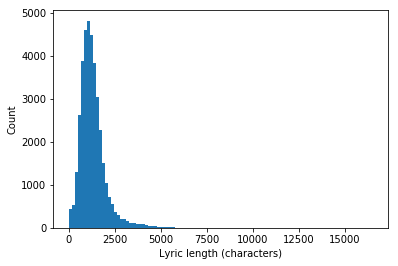

In [14]:
plt.hist(song_lyrics_df['Length'], 100)
plt.xlabel('Lyric length (characters)')
plt.ylabel('Count');

### Inspect  user comments

Comments are contributed by Songmeanings.com users and could vary greatly by length and the level of discussion/interpretation of song lyrics.

In [15]:
song_comments_df.columns = ['ID','Artist','Song','Comment']
song_comments_df['Length'] = song_comments_df['Comment'].apply(lambda x: len(str(x)))
song_comments_df.head()

,ID,Artist,Song,Comment,Length
0,1,A,Starbucks,this song is cool.....xxxxxx\r\n \r\n \r\n,37
1,1,A,Starbucks,"this song rules, so does thier albums. go A!!...",58
2,1,A,Starbucks,"I love it, but itd be nice if sum1 got the ly...",65
3,1,A,Starbucks,any1 know what this song is about?\r\n \r\n \r\n,43
4,1,A,Starbucks,its about what would you rather do: be a rock...,81


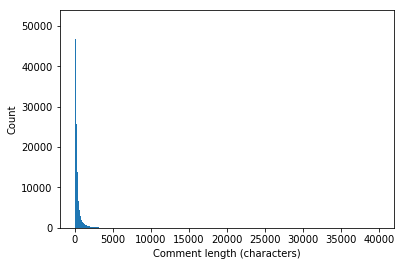

In [16]:
plt.hist(song_comments_df['Length'], 1000)
plt.xlabel('Comment length (characters)')
plt.ylabel('Count');

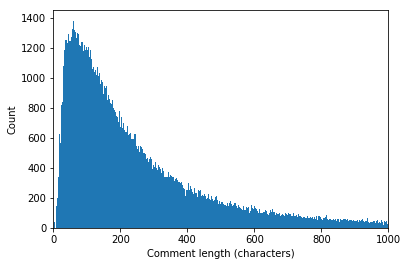

In [17]:
plt.hist(song_comments_df[song_comments_df['Length']<=1000]['Length'], 1000)
plt.xlabel('Comment length (characters)')
plt.xlim(0,1000)
plt.ylabel('Count');

#### How do the contents of shorter vs. longer user comments (by quartiles) differ?

In [18]:
song_comments_df['Length'].describe()

count    375678.000000
mean        356.830014
std         578.471175
min           2.000000
25%          94.000000
50%         190.000000
75%         385.000000
max       40003.000000
Name: Length, dtype: float64

#### Comments with between 0 to 100 characters mostly lack discussion about song content

In [19]:
def remove_linebreak(raw_str):
    out = str(raw_str).replace('\n','').replace('\r','')
    return out

In [20]:
for comment in song_comments_df[song_comments_df['Length']<=100]['Comment'].sample(4, random_state = 1):
    print(remove_linebreak(comment)+'\n')

 Now *this* is a really good song.  

 Where can i find the interviews?  

 This song is awesome. And you can clearly see what the lyrics are about. Great song...  

 I love this song so much, I shouldn't, but I do.  



#### Comments with between 100 and 200 characters show some discussion about what the song is about

In [21]:
for comment in song_comments_df[(song_comments_df['Length']>100) & 
                                (song_comments_df['Length']<=200)]['Comment'].sample(4, random_state = 42):
    print(remove_linebreak(comment)+'\n')

 this is about war!whether its between God and satan,or if its between to colliding men.........  

 what cd is this one on?  i thought i'd heard all the metric songs, guess not! it looks good though.  

 i think this song is about two people who love each other no matter how low they are in society. Its sayin that they will love each other no matter what.  

 I always thought he was saying "It's a corn beef sky" instead of "orangey sky" hahaha. Anyway, just bought this on vinyl, it's a great album and song.   



#### Comments with between 200 and 400 characters contain more detailed descriptions of songs, sometimes quotes song lyrics

In [22]:
for comment in song_comments_df[(song_comments_df['Length']>200) & 
                                (song_comments_df['Length']<=400)]['Comment'].sample(4, random_state = 0):
    print(remove_linebreak(comment)+'\n')

 Yeah.  Not only is he trying to tell kids to be better people, I felt he was also trying to shy them away from the evils of the music industry and the artists and images that promote those evils.  

 Even though iÂ´m not a Miley Cyrus neither a Jonas brother fan  I think this song is excellent and one of their best songs.  They sound great together.  This song is very powerful and meaningful. It is about their break up, but now they are back together  iÂ´m happy for them they are great together.  

 I totally agree with you, this song is very powerful. I love the subliminal sounds, like: don't go and leave me sounds like don't "god" leave me...   My favorite line is also your eyes forever glued to mine, it's standing in my msn nick at the moment :).  I trully believe this song is one of placebo's best work ever. Can't wait to see the video on this one...  

 Its kind of funny to me, my interpretation may be different from the majority, but I think its pretty dark. To me its a man infe

#### Comments with more than 400 characters contain a high level of detailed specifics

In [23]:
for comment in song_comments_df[song_comments_df['Length']>400]['Comment'].sample(4, random_state = 7):
    print(remove_linebreak(comment)+'\n')

 Another song about a trip. He's visiting God, or a god, or a force, or whatever he believes to be the all-powerful, and he became that force. Lots of people who take psychedelic drugs feel like everything in the world is tied together through a unifying force, and that's what this song is talking about. He lived his whole life and now he's beyond life, and wants the girl to do the same. "I'm everything." That means he's her too, so she's him, and everything is everything.  

 i think this song is about how a girl feels about a guy who has kind of screwed her over.  but at the same time, i think the guy in the song still sort of likes her and wants to be friends with her, but she just "needs to forget" because this guy makes her feel worse about herself.  so its like her telling the guy shes over him because he didnt treat her like a friend at all and especially not like something special, hence the break up.  thats just my take on it and especially since i like am going through this s

---
#### Drop short and long comments.

In [24]:
len(song_comments_df['ID'].unique())

37624

In [25]:
song_comments_df = song_comments_df[song_comments_df["Length"] >= 400]
song_comments_df = song_comments_df[song_comments_df["Length"] <= 20000]
song_comments_df.head()

,ID,Artist,Song,Comment,Length
17,2,A Black Rose Burial,A Baleful Aura In The Graveyard Of Broken Gears,it almost seems random. but it could be descr...,623
22,3,A Change of Pace,A Farewell to a Friendship,I can't believe there is only one comment on ...,550
26,3,A Change of Pace,A Farewell to a Friendship,a change of pace is such an amazing band and ...,586
28,3,A Change of Pace,A Farewell to a Friendship,I understand this song can relate strongly to...,1121
29,3,A Change of Pace,A Farewell to a Friendship,i think the meaning of this song is quite obv...,644


In [26]:
len(song_comments_df['ID'].unique())

30772

### Clean text: lowercase, tokenize, lemmatize, drop stopwords

In [27]:
# Drop rows with empty cells
song_lyrics_df['Lyrics'].replace('', np.nan, inplace=True)
song_lyrics_df.dropna(subset=['Lyrics'], inplace=True)

song_comments_df['Comment'].replace('', np.nan, inplace=True)
song_comments_df.dropna(subset=['Comment'], inplace=True)

In [28]:
# Run once
# nltk.download('wordnet')
# nltk.download('stopwords')
# nltk.download('averaged_perceptron_tagger')

tokenizer = RegexpTokenizer(r'\w+') # retains alphanumeric character
lmtzr = WordNetLemmatizer()
cached_stop_words = stopwords.words("english")

# Add more stop words
cached_stop_words.extend(['lyric','song','band','album','instrumental','think','person','people','someone','really','know',
                       'like','want','feel','dont','great','wa','one','ha','oh','yeah','hey','never','say','ooh','get',
                       'got','u','heard','gonna','wanna','thing','could','let','go','meaning','chorus','would','something',
                         'thought','would','still','something','around','little','nothing','everything','always','better',
                          'cause','still','going','gotta','maybe','going','everyone','everybody','anyone','anybody','anything',
                         'interpretation','comment','stuff','sound','thats','others','forget', 'place', 'moment', 'music',
                          'matter', 'comment', 'verse', 'version', 'sound', 'track', 'interpretation', 'guess', 'reminds', 
                          'singer','cd','lot','way','ah','line','part','day','word','doe','opinion','relate','doesnt','lol','listen','haha'])

def lemmatize_dropstop_words(text): 
    return [lmtzr.lemmatize(word) for word in text if lmtzr.lemmatize(word) not in cached_stop_words]

# (len(lmtzr.lemmatize(word))>4)

# Optional filter to only keep nouns in the text
def keep_noun(text):
    tagged = nltk.pos_tag(text)
    nouns = [word for word,pos in tagged if (pos == 'NN' or pos == 'NNP' or pos == 'NNS' or pos == 'NNPS')]
    return nouns

In [29]:
# Pre-processed lyrics
song_lyrics_df['Lyrics_tokens'] = song_lyrics_df['Lyrics'].str.lower().apply(tokenizer.tokenize).apply(lemmatize_dropstop_words)
#song_lyrics_df['Lyrics_tokens'] = song_lyrics_df['Lyrics_tokens'].apply(keep_noun)
song_lyrics_df.head()

,ID,Artist,Song,Lyrics,Length,Lyrics_tokens
0,1,A,Starbucks,"She's silver rich, I cannot take no more yeah ...",1799,"[silver, rich, cannot, take, quit, pretty, nic..."
1,2,A Black Rose Burial,A Baleful Aura In The Graveyard Of Broken Gears,far beyond appolyons lair \r\r\nacross the se...,1572,"[far, beyond, appolyons, lair, across, sea, pe..."
2,3,A Change of Pace,A Farewell to a Friendship,In a dream \r\nIn a place \r\nWhere the far re...,1376,"[dream, far, reach, mind, seen, true, nightmar..."
3,4,A Change of Pace,Loose Lips Sink Ships,So I made you lie! \r\n \r\nAnd we both hope \...,1146,"[made, lie, hope, pas, life, standing, broken,..."
4,5,A Change of Pace,Shoot From The Hip,Picture perfect turned to worthless \r\nBitter...,1611,"[picture, perfect, turned, worthless, bittersw..."


In [30]:
# Pre-processed comments
song_comments_df['Comment_tokens'] = song_comments_df['Comment'].str.lower().apply(tokenizer.tokenize).apply(lemmatize_dropstop_words)
# song_comments_df['Comment_tokens'] = song_comments_df['Comment_tokens'].apply(keep_noun)
song_comments_df.head()

,ID,Artist,Song,Comment,Length,Comment_tokens
17,2,A Black Rose Burial,A Baleful Aura In The Graveyard Of Broken Gears,it almost seems random. but it could be descr...,623,"[almost, seems, random, describing, event, rob..."
22,3,A Change of Pace,A Farewell to a Friendship,I can't believe there is only one comment on ...,550,"[believe, guy, friend, girl, together, broke, ..."
26,3,A Change of Pace,A Farewell to a Friendship,a change of pace is such an amazing band and ...,586,"[change, pace, amazing, deserve, much, popular..."
28,3,A Change of Pace,A Farewell to a Friendship,I understand this song can relate strongly to...,1121,"[understand, strongly, dating, good, even, bes..."
29,3,A Change of Pace,A Farewell to a Friendship,i think the meaning of this song is quite obv...,644,"[quite, obvious, dating, best, friend, falling..."


#### Most common words in lyrics

In [31]:
lyrics_words = []
for sublist in song_lyrics_df['Lyrics_tokens']:
    for item in sublist:
        lyrics_words.append(item)
        
lyrics_fdist = FreqDist(lyrics_words)
lyrics_fdist.most_common(200)

[('love', 39873),
 ('time', 33624),
 ('see', 28582),
 ('come', 26542),
 ('take', 24432),
 ('make', 24051),
 ('back', 22289),
 ('away', 22042),
 ('life', 20096),
 ('right', 16665),
 ('eye', 16151),
 ('need', 15512),
 ('heart', 15280),
 ('baby', 14940),
 ('tell', 14613),
 ('night', 14439),
 ('world', 14161),
 ('said', 13707),
 ('girl', 13431),
 ('well', 13237),
 ('give', 13186),
 ('keep', 12304),
 ('look', 12275),
 ('man', 12150),
 ('hand', 11394),
 ('la', 10972),
 ('good', 10750),
 ('find', 10678),
 ('every', 10640),
 ('ever', 10530),
 ('mind', 10507),
 ('home', 10158),
 ('long', 10044),
 ('light', 9988),
 ('head', 9688),
 ('face', 9244),
 ('inside', 9168),
 ('alone', 9016),
 ('dream', 8754),
 ('gone', 8627),
 ('fall', 8496),
 ('hold', 8397),
 ('end', 8287),
 ('leave', 8212),
 ('friend', 8208),
 ('much', 8160),
 ('tonight', 8122),
 ('turn', 8032),
 ('try', 8005),
 ('left', 7968),
 ('run', 7770),
 ('believe', 7765),
 ('lie', 7763),
 ('hear', 7721),
 ('die', 7691),
 ('boy', 7687),
 ('last

#### Most common words in comments

In [32]:
comment_words = []
for sublist in song_comments_df['Comment_tokens']:
    for item in sublist:
        comment_words.append(item)
        
comments_fdist = FreqDist(comment_words)
comments_fdist.most_common(200)

[('love', 66855),
 ('life', 47369),
 ('time', 44690),
 ('make', 37084),
 ('see', 32027),
 ('back', 25828),
 ('even', 24756),
 ('girl', 23669),
 ('much', 23553),
 ('mean', 23457),
 ('take', 22798),
 ('also', 22614),
 ('come', 21990),
 ('first', 21855),
 ('relationship', 21095),
 ('world', 20983),
 ('good', 19840),
 ('end', 19325),
 ('well', 19056),
 ('god', 18844),
 ('away', 18603),
 ('saying', 18153),
 ('right', 17685),
 ('friend', 16305),
 ('man', 16251),
 ('feeling', 15837),
 ('said', 15571),
 ('guy', 15379),
 ('need', 15361),
 ('though', 14392),
 ('find', 14344),
 ('trying', 14172),
 ('believe', 14130),
 ('tell', 14016),
 ('seems', 13545),
 ('look', 13267),
 ('give', 13244),
 ('ever', 13009),
 ('keep', 12768),
 ('heart', 12738),
 ('many', 12599),
 ('last', 12506),
 ('new', 12294),
 ('mind', 12192),
 ('another', 11989),
 ('made', 11735),
 ('two', 11646),
 ('eye', 11472),
 ('every', 11162),
 ('try', 11141),
 ('live', 11072),
 ('wrong', 11068),
 ('may', 10998),
 ('long', 10848),
 ('yea

Reset index after dropping data

In [33]:
song_lyrics_df = song_lyrics_df.reset_index()
song_lyrics_df.drop(['index'], axis=1, inplace=True)

song_comments_df = song_comments_df.reset_index()
song_comments_df.drop(['index'], axis=1, inplace=True)

---
## Part 3: Use Natural Language Processing to discover similiar songs based on song lyrics and user comments

### Transform texts to vector representation

In [34]:
# Create dictionaries of unique words in the processed tokenized text
lyrics_dict = corpora.Dictionary(song_lyrics_df['Lyrics_tokens'])
comments_dict = corpora.Dictionary(song_comments_df['Comment_tokens'])

print(len(lyrics_dict))
print(len(comments_dict))

63235
109704


In [35]:
# Convert texts to vectors
lyrics_corpus = [lyrics_dict.doc2bow(text) for text in song_lyrics_df['Lyrics_tokens']]
comments_corpus = [comments_dict.doc2bow(text) for text in song_comments_df['Comment_tokens']]

### Do lyrics and comments fall into topics that can be modelled?

#### Topic modeling on lyrics using Latent Dirichlet Allocation (LDA)

In [36]:
# Lyrics LDA model
RETRAIN = False
if RETRAIN == True:
    lyrics_lda = gensim.models.ldamodel.LdaModel(corpus=lyrics_corpus,
                                               id2word=lyrics_dict,
                                               num_topics=50, 
                                               random_state=100,
                                               update_every=1,
                                               chunksize=1000,
                                               passes=1,
                                               alpha='auto',
                                               eta='auto')
else:
    lyrics_lda = gensim.models.ldamodel.LdaModel.load('lyrics_lda')

In [37]:
# lyrics_lda.save('lyrics_lda')

#### Visualize lyrics topics keywords

In [38]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lyrics_lda, lyrics_corpus, lyrics_dict)
vis

C:\ProgramData\Anaconda3\lib\site-packages\numexpr\cpuinfo.py:109: DeprecationWarning: invalid escape sequence \d
  nbits = re.compile('(\d+)bit').search(abits).group(1)
C:\ProgramData\Anaconda3\lib\site-packages\numexpr\cpuinfo.py:662: DeprecationWarning: invalid escape sequence \s
  "\s+stepping\s+(?P<STP>\d+)", re.IGNORECASE)
C:\ProgramData\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]


PreparedData(topic_coordinates=           Freq  cluster  topics         x         y
topic                                               
12     7.990779        1       1 -0.219464  0.037227
28     4.150336        1       2 -0.091333  0.061394
10     3.873654        1       3 -0.161229  0.066248
37     3.817996        1       4 -0.147093 -0.137262
43     3.790500        1       5 -0.170043 -0.097762
6      3.536729        1       6 -0.135055 -0.211662
18     3.255920        1       7 -0.150244  0.087840
17     2.859445        1       8 -0.084276  0.143914
38     2.687663        1       9 -0.161887 -0.001683
48     2.615062        1      10 -0.038832 -0.110750
27     2.478591        1      11 -0.016610 -0.062275
5      2.326093        1      12 -0.058441 -0.083379
19     2.307817        1      13  0.105041  0.098564
9      2.159113        1      14 -0.102611 -0.115491
42     2.133147        1      15 -0.034670  0.066343
14     2.121308        1      16  0.057650  0.120021
16     2.095382        1      17 -0.046266  0.066276
23     2.013667        1      18 -0.081276 -0.092868
44     1.978981        1      19 -0.120050  0.063992
33     1.917129        1      20 -0.117132  0.084563
36     1.894788        1      21  0.163658  0.039275
26     1.894033        1      22  0.031158  0.046576
2      1.867836        1      23  0.167801  0.027429
31     1.802918        1      24 -0.097775  0.018615
35     1.791836        1      25 -0.020294  0.084236
3      1.708273        1      26  0.008157 -0.069946
4      1.624384        1      27  0.145553  0.005139
8      1.604378        1      28 -0.048757  0.018726
47     1.493791        1      29 -0.004389 -0.031123
45     1.384915        1      30  0.019747  0.058939
40     1.359693        1      31  0.068377 -0.045972
32     1.356443        1      32  0.028430  0.091403
29     1.343361        1      33  0.082075  0.077810
24     1.334576        1      34  0.006754  0.015922
25     1.318581        1      35  0.118105 -0.001308
13     1.314750        1      36  0.093325 -0.138306
7      1.285465        1      37  0.005839 -0.066375
0      1.282504        1      38  0.049590  0.125867
21     1.264988        1      39  0.040588  0.085568
39     1.208726        1      40  0.069400 -0.035214
30     1.146290        1      41  0.037140 -0.025517
15     1.118795        1      42  0.008935  0.024790
34     1.064863        1      43 -0.043657 -0.012377
11     1.056424        1      44  0.052474 -0.037163
41     1.023428        1      45  0.113514  0.033137
49     0.922768        1      46  0.187760 -0.123868
46     0.905498        1      47  0.179323 -0.113293
1      0.889938        1      48  0.064035  0.013063
20     0.841160        1      49  0.168534 -0.045766
22     0.785289        1      50  0.078425 -0.003519, topic_info=      Category          Freq        Term         Total  loglift  logprob
term                                                                    
186    Default  40477.000000        love  40477.000000  30.0000  30.0000
10     Default  25612.000000        come  25612.000000  29.0000  29.0000
305    Default  22248.000000        back  22248.000000  28.0000  28.0000
209    Default  14647.000000        baby  14647.000000  27.0000  27.0000
178    Default  13327.000000        give  13327.000000  26.0000  26.0000
698    Default   9736.000000          la   9736.000000  25.0000  25.0000
287    Default  12968.000000        girl  12968.000000  24.0000  24.0000
27     Default  15397.000000        need  15397.000000  23.0000  23.0000
36     Default  24712.000000        take  24712.000000  22.0000  22.0000
428    Default  12891.000000         man  12891.000000  21.0000  21.0000
2      Default  22736.000000        away  22736.000000  20.0000  20.0000
325    Default  14033.000000       night  14033.000000  19.0000  19.0000
444    Default   8052.000000     believe   8052.000000  18.0000  18.0000
259    Default  23657.000000        make  23657.000000  17.0000  17.0000
433    Default   8078.000000     

#### Topic modeling on comments using Latent Dirichlet Allocation (LDA)

In [39]:
# Comments LDA model
if RETRAIN == True:
    comments_lda = gensim.models.ldamodel.LdaModel(corpus=comments_corpus,
                                               id2word=comments_dict,
                                               num_topics=25, 
                                               random_state=100,
                                               update_every=1,
                                               chunksize=1000,
                                               passes=1,
                                               alpha='auto',
                                               eta='auto')
else:
    comments_lda = gensim.models.ldamodel.LdaModel.load('comments_lda')

In [40]:
# comments_lda.save('comments_lda')

#### Visualize comments topics keywords

In [41]:
vis2 = pyLDAvis.gensim.prepare(comments_lda, comments_corpus, comments_dict)
vis2

C:\ProgramData\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]


PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
6      28.844419        1       1  0.018478  0.221012
1      15.279676        1       2  0.047085  0.244918
4       6.478731        1       3  0.002939  0.153491
20      5.164996        1       4 -0.202480  0.077611
9       4.301617        1       5  0.128410  0.106103
19      3.393638        1       6 -0.164047 -0.039928
8       2.895537        1       7  0.172109  0.017399
23      2.800205        1       8  0.149550 -0.018850
0       2.764257        1       9 -0.090581 -0.035172
17      2.685092        1      10  0.150671 -0.001234
12      2.475738        1      11 -0.071487  0.056633
10      2.404153        1      12 -0.183978  0.104460
21      2.281317        1      13 -0.064132  0.060091
14      1.941489        1      14 -0.029297 -0.008323
3       1.807906        1      15  0.125510  0.024502
11      1.676482        1      16  0.102357 -0.124638
2       1.627892        1      17 -0.088171 -0.033501
7       1.626948        1      18  0.148286 -0.004921
15      1.604087        1      19 -0.014540 -0.130352
22      1.493227        1      20  0.037755 -0.116800
24      1.429424        1      21 -0.111824 -0.113766
13      1.377714        1      22 -0.039506 -0.099629
5       1.339999        1      23 -0.128105 -0.044691
16      1.223105        1      24  0.108285 -0.091452
18      1.082355        1      25 -0.003286 -0.202960, topic_info=      Category          Freq           Term         Total  loglift  logprob
term                                                                       
413    Default  19664.000000            god  19664.000000  30.0000  30.0000
117    Default  67289.000000           love  67289.000000  29.0000  29.0000
1302   Default  10244.000000           drug  10244.000000  28.0000  28.0000
115    Default  50732.000000           life  50732.000000  27.0000  27.0000
1214   Default   7727.000000         father   7727.000000  26.0000  26.0000
1446   Default   6959.000000            war   6959.000000  25.0000  25.0000
55     Default  25109.000000           girl  25109.000000  24.0000  24.0000
93     Default  20268.000000   relationship  20268.000000  23.0000  23.0000
1685   Default   9169.000000          death   9169.000000  22.0000  22.0000
166    Default  10608.000000           year  10608.000000  21.0000  21.0000
543    Default  22098.000000          world  22098.000000  20.0000  20.0000
1374   Default   5429.000000          child   5429.000000  19.0000  19.0000
3396   Default   6303.000000            age   6303.000000  18.0000  18.0000
2488   Default   4577.000000          black   4577.000000  17.0000  17.0000
3517   Default   4331.000000          white   4331.000000  16.0000  16.0000
44     Default  13915.000000        believe  13915.000000  15.0000  15.0000
111    Default  11782.000000            eye  11782.000000  14.0000  14.0000
1358   Default   4107.000000       religion   4107.000000  13.0000  13.0000
2360   Default   5684.000000            son   5684.000000  12.0000  12.0000
263    Default  19177.000000           away  19177.000000  11.0000  11.0000
5713   Default   4651.000000             50   4651.000000  10.0000  10.0000
587    Default   8981.000000          dream   8981.000000   9.0000   9.0000
1401   Default   4305.000000          jesus   4305.000000   8.0000   8.0000
3686   Default   3942.000000       narrator   3942.000000   7.0000   7.0000
2148   Default   5644.000000            sex   5644.000000   6.0000   6.0000
628    Default   5487.000000              2   5487.000000   5.0000   5.0000
356    Default   5436.000000           shit   5436.000000   4.0000   4.0000
5189   Default   3929.000000         sister   3929.000000   3.0000   3.0000
1700   Default   3493.000000        suicide   3493.000000   2.0000   2.0000
501    Default  15690.000000            man  15690.000000   1.0000   1.0000
...        ...           ...            ...           ...      ... 

### Enter a song to find similar songs

In [42]:
# Create vectors that represent topic distribution of each lyric or comment
lyrics_topic_vectors = lyrics_lda[lyrics_corpus]
comments_topic_vectors = comments_lda[comments_corpus]

#### Search by Artist

In [43]:
song_lyrics_df[song_lyrics_df['Artist'] == 'Sia']

,ID,Artist,Song,Lyrics,Length,Lyrics_tokens
30726,30731,Sia,Academia,You can be my alphabet \r\nAnd I will be your ...,1646,"[alphabet, calculator, together, work, escalat..."
30727,30732,Sia,Beautiful Calm Driving,"Beautiful calm driving, deep sea pearl diving ...",688,"[beautiful, calm, driving, deep, sea, pearl, d..."
30728,30733,Sia,Breathe Me,"Help, I have done it again \r\nI have been her...",609,"[help, done, many, time, hurt, today, worst, e..."
30729,30734,Sia,Butterflies,"We've been to the top, we've been to the botto...",1021,"[top, bottom, known, forgotten, kicked, wrappe..."
30730,30735,Sia,Buttons,You got me pushing imaginary buttons \r\nStep ...,1400,"[pushing, imaginary, button, step, away, lover..."
30731,30736,Sia,Chandelier,Party girls don't get hurt \r\nCan't feel anyt...,2024,"[party, girl, hurt, learn, push, push, good, t..."
30732,30737,Sia,Death by Chocolate,Death by chocolate is myth \r\r\nThis I know b...,1043,"[death, chocolate, myth, lived, broken, heart,..."
30733,30738,Sia,Don't Bring Me Down,Faint light of dawn \r\r\nI'm listening to you...,1189,"[faint, light, dawn, listening, breathing, bre..."
30734,30739,Sia,Elastic Heart,And another one bites the dust \r\nBut why can...,1757,"[another, bite, dust, conquer, love, might, fi..."
30735,30740,Sia,I Go To Sleep,When I look up from my pillow \r\nI dream you ...,908,"[look, pillow, dream, though, far, away, near,..."


#### Search by Song

In [44]:
song_lyrics_df[song_lyrics_df['Song'] == 'Chandelier']

,ID,Artist,Song,Lyrics,Length,Lyrics_tokens
30731,30736,Sia,Chandelier,Party girls don't get hurt \r\nCan't feel anyt...,2024,"[party, girl, hurt, learn, push, push, good, t..."


#### Enter song index below

In [45]:
song_index = 30731

#### Recommendations based on similar lyrics

In [46]:
lyrics_sims = []
for i in np.arange(len(lyrics_topic_vectors)):
    sim = gensim.matutils.cossim(lyrics_topic_vectors[song_index], lyrics_topic_vectors[i])
    lyrics_sims.append(sim)
song_lyrics_df['Similarity to input'] = lyrics_sims

In [47]:
song_lyrics_df.sort_values(by=['Similarity to input'], ascending = False).head(10)

,ID,Artist,Song,Lyrics,Length,Lyrics_tokens,Similarity to input
30731,30736,Sia,Chandelier,Party girls don't get hurt \r\nCan't feel anyt...,2024,"[party, girl, hurt, learn, push, push, good, t...",1.000000
13889,13891,Goldfinger,Counting The Days,"So here I go and there you went, again \r\r\nJ...",1526,"[went, another, stupid, done, wrong, locked, h...",0.925622
23423,23428,The National,Ada,"Ada, don't talk about reasons \r\r\nWhy you do...",1446,"[ada, talk, reason, talk, reason, talk, consid...",0.877410
12124,12125,Fall Out Boy,Parker Lewis Can't Lose (But I'm Gonna Give It...,Laughed off my affections \r\nWhile I passed b...,940,"[laughed, affection, passed, direction, known,...",0.876669
13899,13901,Goldfinger,Open Your Eyes,Open your eyes to the millions of lies that th...,1028,"[open, eye, million, lie, tell, every, open, m...",0.862642
32938,32943,Sublime,Boss DJ,There's a steel train comin' through \r\r\nI ...,1422,"[steel, train, comin, take, lie, sunday, morni...",0.859137
18156,18159,Keane,Nothing In My Way,A turning tide \r\nLovers at a great divide \r...,1132,"[turning, tide, lover, divide, laugh, hurt, in...",0.855931
18118,18121,Katy Perry,Use Your Love,I know you know my boyfriend is out of town \r...,1752,"[boyfriend, town, drink, talk, many, sayin, bo...",0.849149
4794,4795,Blue October,"3 Weeks, She Sleeps","For 3 weeks, she sleeps, \r\nthrough the rain....",213,"[3, week, sleep, rain, try, keep, dry, run, se...",0.848058
21261,21266,Maxïmo Park,Nosebleed,You were born in winter \r\nBut summer came to...,1293,"[born, winter, summer, came, fast, child, cont...",0.847413


#### Recommendations based on similar user comments

In [48]:
comments_for_input = song_comments_df[song_comments_df['ID']==song_lyrics_df.iloc[song_index]['ID']].index
print('Number of comments for input song: '+str(len(comments_for_input)))

Number of comments for input song: 6


In [49]:
comments_sims = []
for comment_index in comments_for_input:
    current_comment_sims = []
    for i in np.arange(len(comments_topic_vectors)):
        sim = gensim.matutils.cossim(comments_topic_vectors[comment_index], comments_topic_vectors[i])
        current_comment_sims.append(sim)
    comments_sims.append(current_comment_sims)
comments_sims_df = pd.DataFrame(comments_sims).T
song_comments_df['Max similarity to input'] = comments_sims_df.max(axis=1)

In [50]:
song_comments_df.sort_values(by=['Max similarity to input'], ascending = False).head(20)

,ID,Artist,Song,Comment,Length,Comment_tokens,Max similarity to input
73397,30736,Sia,Chandelier,I think many who have struggled with destruct...,1921,"[many, struggled, destructive, coping, mechani...",1.000000
73400,30736,Sia,Chandelier,IMHO the meager apartment with the family pic...,1512,"[imho, meager, apartment, family, pic, wall, b...",1.000000
73399,30736,Sia,Chandelier,I heard a theory that it's actually about sui...,980,"[theory, actually, suicide, swing, chandelier,...",1.000000
73401,30736,Sia,Chandelier,Party girls don't get hurt \r\nCan't feel any...,3716,"[party, girl, hurt, learn, push, push, trying,...",1.000000
73398,30736,Sia,Chandelier,"From my point of view, Chandelier portrays an...",644,"[point, view, chandelier, portrays, attempt, e...",1.000000
73402,30736,Sia,Chandelier,I love this song!! Beautifully sung and writt...,447,"[love, beautifully, sung, written, believe, tr...",1.000000
8222,3573,Beirut,After the Curtain,"I think of it as a song about the inevitable,...",551,"[inevitable, inevitable, decision, curtain, fa...",0.989059
24173,10184,DJ Sammy,Heaven (9/11 Version),I hate to ruing the...illusion...but the girl...,488,"[hate, ruing, illusion, girl, lose, father, fa...",0.987743
58023,24401,No Use For A Name,Friends Of The Enemy,I think this song is about the fear of enteri...,559,"[fear, entering, relationship, worst, took, wh...",0.986947
65890,27708,Queens of the Stone Age,A Song For The Deaf,"Hi! this is like my first post here, but I th...",1991,"[hi, first, post, found, connection, previous,...",0.986662
